<a href="https://colab.research.google.com/github/paulovictorcorreia/anomaly-detection-sax/blob/main/Plotting_Results_of_the_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Implementação Detecção de Anomalias com Pytorch

Neste notebook, será implementado o *notebook* com pipeline de detecção de anomalias em processos industriais com LSTM.
Nesta seção importaremos os pacotes utilizados e as classes utilizadas para fazer o préprocessamento do pipeline, além de instalar os pacotes python que serão utilizados neste notebook.

In [ ]:
!pip install pyts skorch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, ClassifierMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, jaccard_score, roc_auc_score, precision_score, f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from pyts.approximation import PiecewiseAggregateApproximation, SymbolicAggregateApproximation
from scipy.ndimage.interpolation import shift

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision.transforms as transforms
from skorch import NeuralNetClassifier

     |████████████████████████████████| 2.5MB 6.6MB/s 
     |████████████████████████████████| 133kB 39.2MB/s 


In [ ]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ] 

class SaxTransformer(BaseEstimator, TransformerMixin):
    # Class constructor
    def __init__(self, alphabet_size=8, window_size=100):
        self.alphabet_size = alphabet_size
        self.window_size = window_size
        self.alphabet = "abcdefghijklmnopqrstuvwxyz"
        self.alphabet = self.alphabet[:alphabet_size]
    # Return Self, nothing else to do here
    def fit(self, X, y=None):
        return self 
    # Method that describes what this method needs to do
    def transform(self, X, y=None):
        print(f"Memória ocupada antes da compressão (kB): {X.nbytes/1000.0}")
        words = []
        num_cols = X.shape[1]
        for col in range(num_cols):
            paa_transformer = PiecewiseAggregateApproximation(
                window_size=self.window_size)
            data_paa = paa_transformer.transform(X[:, col].reshape(1, -1))
            sax_transformer = SymbolicAggregateApproximation(
                n_bins=self.alphabet_size, 
                strategy="normal")
            word = sax_transformer.transform(data_paa)
            words.append(word)
        words_att = []
        for i in range(num_cols):
            words_att.append(words[i][0])
        output = pd.DataFrame(words_att).transpose()
        print(f"Memória ocupada após a compressão (kB): {output.values.nbytes/1000.0}", )     
        output = self.symbol2num(output)
        return output
    
    
    def symbol2num(self, X):
        '''
        Convert SAX symbols to ordered numbers from 0 up to 1.
        '''
        num_rows = X.shape[0]
        num_cols = X.shape[1]
        values_consult_table = {
            k: v for v, k in enumerate(sorted(set(self.alphabet)))
            } 
        numbers_from_char = np.empty((num_rows, num_cols))
        for i in range(num_cols):
            for j in range(num_rows):
                numbers_from_char[j, i] = values_consult_table[X.iloc[j, i]]
        numbers_from_char = np.array(numbers_from_char)
        numbers_from_char = np.array(
            list(map(lambda x: x/(self.alphabet_size - 1), numbers_from_char))
            )
        return numbers_from_char

class GeradorAtrasos(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__( self, delays=1):
        self.delays = delays
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        num_cols = X.shape[1]
        num_rows = X.shape[0]
        num_delays = self.delays + 1
        # delays_array = np.empty((num_rows, num_cols))
        delays = []
        for i in range(num_cols):
            for j in range(num_delays):
                delays.append(shift(X[:, i], 1, cval=np.nan))
        delays = np.array(delays).transpose()
        delays = pd.DataFrame(delays)
        delays.fillna(method="bfill", inplace=True)
        return delays

# 2 Implementando *Deep Learning*

Aqui implementaremos a classe adaptada para detectar anomalias. Utilizaremos o Pytorch para montar a classe do detector e o *skorch*.

In [ ]:
# PyTorch Class
# torch.manual_seed(42)
class TorchLSTM(nn.Module):
    def __init__(self, num_inputs=10, num_units=15, num_layers=1):
        super(TorchLSTM, self).__init__()
        # LSTM parameters
        self.num_inputs = num_inputs
        self.num_units = num_units
        self.num_layers = num_layers

        # Layers of neurons
        self.feature = nn.LSTM(num_inputs, num_units, num_layers)
        self.linear1 = nn.Linear(num_units, num_units)     
        self.output = nn.Linear(num_units, 1)

        # States
        self.hidden_state = torch.zeros((1, 1, num_units))
        self.cell_state = torch.zeros((1, 1, num_units))

        # Activation Functions and Dropout
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    
    def forward(self, x):
        x = x.transpose(1, 2)
        x, (hs, cs) = self.feature(x)
        # self.hidden_state = hs 
        # self.cell_state = cs
        # print(hs, cs)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.output(x)
        x = self.sigmoid(x)
        x = x.squeeze()
        
        return x



In [ ]:
# Class to use on Pipeline
class AnomalyLSTMDetector(BaseEstimator, ClassifierMixin):
    def __init__(self, start, end, num_units=15, 
                num_layers=1, batch_size=10, random_state=None, verbose=0,
                max_epochs=200, lr=0.01,):

        # Neural Network Parameters and models
        self.model = None
        self.num_inputs = 0
        self.num_units = num_units
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.random_state = random_state
        self.verbose = verbose
        self.max_epochs = max_epochs
        self.lr = lr
        
        

        
        # Indice adjustment for target array
        self.start = start
        self.end = end

    def fit(self, X, y):
        torch.manual_seed(self.random_state)
        self.num_inputs = X.shape[1]
        # Modelo criado no Fit por causa do tamanho da entrada que deve
        # ser especificado pelo dataset utilizado.
        self.model = NeuralNetClassifier(TorchLSTM(self.num_inputs, self.num_units, self.num_layers, ), 
                                        max_epochs=self.max_epochs, lr=self.lr,
                                        train_split=None, criterion=nn.BCELoss,
                                        batch_size=32, iterator_train__shuffle=False,
                                        optimizer=torch.optim.Adam, verbose=self.verbose)
        
        word_size = X.shape[0]

        # Transformando target 'y' em tensor do tipo Float para
        # o modelo funcionar corretamente
        y_transformed = self.transforma_saida(self.start, self.end, 
                                              y, word_size)
        y_transformed = torch.tensor(y_transformed)
        y_transformed =  y_transformed.type(torch.FloatTensor)

        # Transformando as features em tensores no formato correto para
        # o modelo funcionar corretamente.
        num_rows = X.shape[0]
        num_cols = X.shape[1]
        X_transformed = X.values.reshape(num_rows, num_cols, 1)
        X_transformed = X_transformed.astype(np.float32)
        self.model.fit(X_transformed, y_transformed)
        return self


    def predict(self, X, y=None):
        X = X.values
        num_rows = X.shape[0]
        num_cols = X.shape[1]
        X = X.reshape(num_rows, num_cols, 1)
        X = X.astype(np.float32)
        y_pred = self.model.forward(X)        
        y_pred = (y_pred > 0.5)
        y_pred = self.filtrar_media_movel(y_pred)
        return y_pred

    def filtrar_media_movel(self, y):
        '''
        Aplica o filtro da média móvel no vetor de saída do modelo.
        '''
        y_filttered = pd.Series(y.flatten())
        y_filttered = y_filttered.rolling(window=5).mean()
        y_filttered = y_filttered.round().fillna(0).astype(int)
        return y_filttered

    def transforma_saida(self, start, end, ts, word_size):
        '''
        Converte a saída do modelo do domínio da amostragem original para o domínio
        da transformação SAX.
        '''
        size = len(ts)
        compression_rate = size / word_size
        output = np.zeros(word_size)
        for i in range(len(start)):
            low = int(start[i] / compression_rate)
            high = int(end[i] / compression_rate)
            output[low:high] = 1
        return output

# 3 Criando Pipeline para a detecção de anomalias



In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/Pesquisa em Detecção de Anomalias/Notebooks'

Mounted at /gdrive
/gdrive/My Drive/Pesquisa em Detecção de Anomalias/Notebooks


In [ ]:
# !unzip DadosCBA.zip
falha1_treino = pd.read_csv("DadosCBA/falha1_100_110.csv")
falha1_treino["anomalia"] = 0
falha1_treino.loc[10000:11000, "anomalia"] = 1
falha1_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15801 entries, 0 to 15800
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TOUT      15801 non-null  float64
 1   XMEAS01   15801 non-null  float64
 2   XMEAS02   15801 non-null  float64
 3   XMEAS03   15801 non-null  float64
 4   XMEAS04   15801 non-null  float64
 5   XMEAS05   15801 non-null  float64
 6   XMEAS06   15801 non-null  float64
 7   XMEAS07   15801 non-null  float64
 8   XMEAS08   15801 non-null  float64
 9   XMEAS09   15801 non-null  float64
 10  XMEAS10   15801 non-null  float64
 11  XMEAS11   15801 non-null  float64
 12  XMEAS12   15801 non-null  float64
 13  XMEAS13   15801 non-null  float64
 14  XMEAS14   15801 non-null  float64
 15  XMEAS15   15801 non-null  float64
 16  XMEAS16   15801 non-null  float64
 17  XMEAS17   15801 non-null  float64
 18  XMEAS18   15801 non-null  float64
 19  XMEAS19   15801 non-null  float64
 20  XMEAS20   15801 non-null  fl

In [ ]:
feature_names = ["XMEAS01", "XMEAS10", "XMEAS21"]
alphabet_size = 7
window_size = 35
delays = 5
random_state = 42
teste_pipeline = Pipeline(steps=[
    ("ftr_sel", FeatureSelector(feature_names=feature_names)),
    ("std_scl", StandardScaler()),
    ("sax", SaxTransformer(alphabet_size=alphabet_size, 
                           window_size=window_size)),
    ("delays", GeradorAtrasos(delays=delays)),
    ("clf", AnomalyLSTMDetector(start=[10000], end=[11000], 
                                random_state=random_state)),
])


In [ ]:
def transforma_saida(start, end, ts, window_size):
    size = len(ts)
    word_size = int(np.ceil(size / window_size))
    compression_rate = size / word_size
    output = np.zeros(word_size)
    low = int(start / compression_rate)
    high = int(end / compression_rate)
    output[low:high] = 1
    # output = pd.get_dummies(output).values
    return output


In [ ]:
saida_treinamento = transforma_saida(10000, 11000, falha1_treino, window_size)
y_train = np.zeros(falha1_treino.shape[0])
y_train[10000:11000] = 1
y_train = pd.get_dummies(y_train).values
variavel1 = teste_pipeline.fit(falha1_treino, y_train)
print(teste_pipeline["std_scl"].mean_)
print(teste_pipeline["std_scl"].scale_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.4081  0.5189
      2        0.2589  0.1932
      3        0.2471  0.1940
      4        0.2505  0.1973
      5        0.2430  0.2066
      6        0.2520  0.1927
      7        0.2474  0.1980
      8        0.2426  0.2052
      9        0.2453  0.1964
     10        0.2428  0.1873
     11        0.2358  0.1915
     12        0.2386  0.1884
     13        0.2401  0.2077
     14        0.2357  0.2014
     15        0.2318  0.1932
     16        0.2321  0.1956
     17        0.2255  0.2007
     18        0.2142  0.2017
     19        0.2187  0.2040
     20        0.2122  0.2047
     21        0.2067  0.1900
     22        0.1980  0.1901
     23        0.2008  0.1994
     24        0.2010  0.1947
     25        0.1921  0.1955
     26        0.1945  0.1971
     27        0.1904  0.1922
     28        0.1882  0.2067
     29        0.1818  0.1949
     30        0.1807  0.1898
     31        0.1837  0.1876
     32   

In [ ]:
from sklearn.metrics import classification_report


y_pred = teste_pipeline.predict(falha1_treino)
# y_pred = torch.round(torch.tensor(y_pred))
y_pred = np.array(y_pred)
print("\t\t\t\t" + classification_report(saida_treinamento, y_pred, digits=3))


				              precision    recall  f1-score   support

         0.0      0.992     0.997     0.995       741
         1.0      0.957     0.880     0.917        50

    accuracy                          0.990       791
   macro avg      0.974     0.939     0.956       791
weighted avg      0.990     0.990     0.990       791



# CBA - Replicação dos Resultados

Nesta sessão, replicaremos os resultados do CBA com o pipeline que utiliza o Pytorch

In [ ]:
def filter_time(signal_input,e1 = 20, e2 = 60):
  result = []
  for i in range(e1):
    result.append(0)
  for i in range(e1, len(signal_input)):
    if(signal_input[i] == 0 and np.sum(signal_input[i-e1:i] == signal_input[i]) == e1):
      result.append(signal_input[i])
    elif(signal_input[i] != 0 and  np.sum(signal_input[i-e2:i] == signal_input[i]) == e2):
      result.append(signal_input[i])
    else:
      result.append(result[len(result)-1])
  return np.array(result)

def plot_predictions(dataset, modelo, falhas_localizacao_inicio, falhas_localizacao_fim, feature_names, title=""):
    y_test = modelo.predict(dataset)
    y_test =  1 * (y_pred > 0.5)
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    num_plots = len(feature_names)
    colors = ["blue", "orange", "magenta", "pink"]
    fig, ax = plt.subplots(num_plots, 1, sharex=True, sharey=True)
    fig.subplots_adjust(top=0.98, bottom=0.1, left=0.10, right=0.95, hspace=0.07,
                        wspace=0.35)
    
    fig.set_figheight(2*num_plots)
    fig.set_figwidth(6)
    fig.suptitle(title)
    window_len = modelo["sax"].window_size
    dataset_normalized = scaler.fit_transform(dataset[feature_names])
    print(window_len, dataset_normalized.shape)
    for i in range(num_plots):
        ax[i].plot(dataset_normalized[:, i], label=feature_names[i], color="darkblue")
        ax[i].legend(loc="upper left", fancybox=True, shadow=True, borderpad=0.25)
        # ax[i].axvspan(discords[i][0], discords[i][0] + window_size, color="red", alpha=0.5)
        ax[i].plot(np.arange(0, dataset_normalized.shape[0], window_len), y_test, color="red")
        for j in range(len(falhas_localizacao_inicio)):
            ax[i].axvspan(falhas_localizacao_inicio[j], falhas_localizacao_fim[j], color="grey", alpha=0.5)
    plt.show()


# plot_predictions(falha13_20, best_model_fixed_delay_13, [9000, 14800], [10000, 15800], feature_names, "aaaaaaa")

In [ ]:
falha1 = pd.read_csv("DadosCBA/falha1_100_110.csv")
falha1["estado"] = 0
falha1.loc[10000:11000, "estado"] = 1

falha2 = pd.read_csv("DadosCBA/falha2_100_110.csv")
falha2["estado"] = 0
falha2.loc[10000:11000, "estado"] = 1

falha8 = pd.read_csv("DadosCBA/falha8_120_130.csv")
falha8["estado"] = 0
falha8.loc[12000:13000, "estado"] = 1

falha13 = pd.read_csv("DadosCBA/falha13_120_130.csv")
falha13["estado"] = 0
falha13.loc[12000:13000, "estado"] = 1

falha20 = pd.read_csv("DadosCBA/falha20_120_130.csv")
falha20["estado"] = 0
falha20.loc[12000:13000, "estado"] = 1

In [ ]:
feature_names = ["XMEAS01", "XMEAS10", "XMEAS21",]
alphabet_size = 7
window_size = 35
delays = 5
pipeline_artigo_repl = Pipeline(steps=[
    ("ftr_sel", FeatureSelector(feature_names=feature_names)),
    ("std_scl", StandardScaler()),
    ("sax", SaxTransformer(alphabet_size=alphabet_size, window_size=window_size)),
    ("delays", GeradorAtrasos(delays=delays)),
    ("clf", AnomalyLSTMDetector(start=[12000], end=[13000],
                                random_state=42)),
])
pipeline_artigo_repl.fit(falha8, falha8["estado"])
print("Done")

Memória ocupada antes da compressão (kB): 427.224
Memória ocupada após a compressão (kB): 12.216
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5043  0.4276
      2        0.3018  0.1874
      3        0.2369  0.1830
      4        0.2297  0.1809
      5        0.2408  0.1422
      6        0.2283  0.1331
      7        0.2308  0.1321
      8        0.2285  0.1441
      9        0.2325  0.1360
     10        0.2281  0.1339
     11        0.2199  0.1322
     12        0.2205  0.1361
     13        0.2212  0.1407
     14        0.2159  0.1363
     15        0.2108  0.1407
     16        0.2104  0.1329
     17        0.2046  0.1781
     18        0.2027  0.1787
     19        0.1941  0.1339
     20        0.1830  0.1323
     21        0.1747  0.1352
     22        0.1697  0.1463
     23        0.1564  0.1381
     24        0.1388  0.1369
     25        0.1332  0.1402
     26        0.1311  0.1399
     27        0.1847  0.1341
     28        0.2153  0.1381
   

In [ ]:
def transforma_saida(start, end, ts, word_size):
    size = len(ts)
    compression_rate = size / word_size
    output = np.zeros(word_size)
    low = int(start / compression_rate)
    high = int(end / compression_rate)
    output[low:high] = 1
    return output

def recall_modified(y_true, y_test):
    size_y_test = y_test.shape[0]
    y_true_modified = transforma_saida(12000, 13000, y_true, size_y_test)
    return recall_score(y_true_modified, y_test)

def jaccard_modified(y_true, y_test):
    size_y_test = y_test.shape[0]
    y_true_modified = transforma_saida(12000, 13000, y_true, size_y_test)
    return jaccard_score(y_true_modified, y_test)

def accuracy_modified(y_true, y_test):
    size_y_test = y_test.shape[0]
    y_true_modified = transforma_saida(12000, 13000, y_true, size_y_test)
    return accuracy_score(y_true_modified, y_test)

def precision_modified(y_true, y_test):
    size_y_test = y_test.shape[0]
    y_true_modified = transforma_saida(12000, 13000, y_true, size_y_test)
    return precision_score(y_true_modified, y_test)

def f1_modified(y_true, y_test):
    size_y_test = y_test.shape[0]
    y_true_modified = transforma_saida(12000, 13000, y_true, size_y_test)
    # print((y_true_modified.shape))
    # print(y_test.shape)
    return f1_score(y_true_modified, y_test)

def roc_auc_modified(y_true, y_test):
    size_y_test = y_test.shape[0]
    y_true_modified = transforma_saida(12000, 13000, y_true, size_y_test)
    return f1_score(y_true_modified, y_test)
scoring = {
    'recall': make_scorer(recall_modified), 'Precision': make_scorer(precision_modified), 'f1_score': make_scorer(f1_modified),
    'Accuracy': make_scorer(accuracy_modified),
}




In [ ]:
from sklearn.metrics import classification_report
def print_scores(y_test, y_pred):
    print(f"Acc_score: {accuracy_score(y_test, y_pred)}")
    print(f"precision_score: {precision_score(y_test, y_pred)}")
    print(f"recall_score: {recall_score(y_test, y_pred)}")
    print(f"f1_score: {f1_score(y_test, y_pred)}")


y_pred = pipeline_artigo_repl.predict(falha1)
# y_pred = torch.round(torch.tensor(y_pred))
y_test = transforma_saida(10000, 11000, falha1, len(y_pred))
print(classification_report(y_test, y_pred, digits=3), )

Memória ocupada antes da compressão (kB): 379.224
Memória ocupada após a compressão (kB): 10.848
              precision    recall  f1-score   support

         0.0      0.990     0.974     0.982       424
         1.0      0.686     0.857     0.762        28

    accuracy                          0.967       452
   macro avg      0.838     0.916     0.872       452
weighted avg      0.972     0.967     0.969       452



Memória ocupada antes da compressão (kB): 379.224
Memória ocupada após a compressão (kB): 10.848
35 (15801, 3)


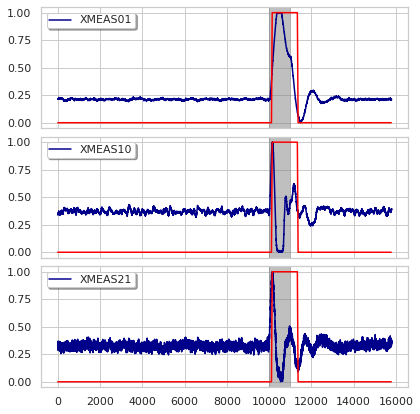

In [ ]:
from sklearn.preprocessing import MinMaxScaler
plot_predictions(falha1, pipeline_artigo_repl, [10000], [11000], feature_names, "")

In [ ]:
def print_scores(y_test, y_pred):
    print(f"Acc_score: {accuracy_score(y_test, y_pred)}")
    print(f"precision_score: {precision_score(y_test, y_pred)}")
    print(f"recall_score: {recall_score(y_test, y_pred)}")
    print(f"f1_score: {f1_score(y_test, y_pred)}")


y_pred = pipeline_artigo_repl.predict(falha2)
# print(y_pred.size())
# y_pred = torch.round(torch.tensor(y_pred))
y_test = transforma_saida(10000, 11000, falha2, len(y_pred))
print(classification_report(y_test, y_pred, digits=3), )


Memória ocupada antes da compressão (kB): 379.224
Memória ocupada após a compressão (kB): 10.848
              precision    recall  f1-score   support

         0.0      0.974     0.976     0.975       424
         1.0      0.630     0.607     0.618        28

    accuracy                          0.954       452
   macro avg      0.802     0.792     0.797       452
weighted avg      0.953     0.954     0.953       452



Memória ocupada antes da compressão (kB): 379.224
Memória ocupada após a compressão (kB): 10.848
35 (15801, 3)


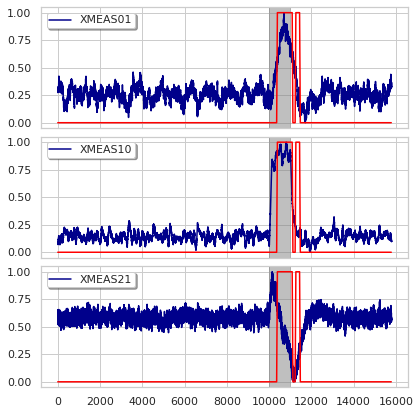

In [ ]:
plot_predictions(falha2, pipeline_artigo_repl, [10000], [11000], feature_names, "")


In [ ]:
def print_scores(y_test, y_pred):
    print(f"Acc_score: {accuracy_score(y_test, y_pred)}")
    print(f"precision_score: {precision_score(y_test, y_pred)}")
    print(f"recall_score: {recall_score(y_test, y_pred)}")
    print(f"f1_score: {f1_score(y_test, y_pred)}")


y_pred = pipeline_artigo_repl.predict(falha8)
# print(y_pred.size())
# y_pred = torch.round(torch.tensor(y_pred))
y_test = transforma_saida(12000, 13000, falha8, len(y_pred))
print(classification_report(y_test, y_pred, digits=3), )


Memória ocupada antes da compressão (kB): 427.224
Memória ocupada após a compressão (kB): 12.216
              precision    recall  f1-score   support

         0.0      0.988     0.996     0.992       481
         1.0      0.917     0.786     0.846        28

    accuracy                          0.984       509
   macro avg      0.952     0.891     0.919       509
weighted avg      0.984     0.984     0.984       509



Memória ocupada antes da compressão (kB): 427.224
Memória ocupada após a compressão (kB): 12.216
35 (17801, 3)


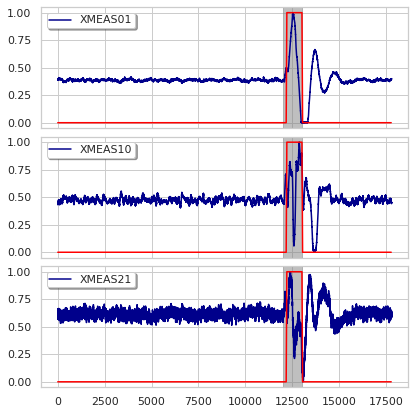

In [ ]:
plot_predictions(falha8, pipeline_artigo_repl, [12000], [13000], feature_names, "")

# Generalizando Treinamento e Plotando Gráficos

In [ ]:
falha1 = pd.read_csv("DadosCBA/falha1_100_110.csv")
falha1["estado"] = 0
falha1.loc[10000:11000, "estado"] = 1

falha2 = pd.read_csv("DadosCBA/falha2_100_110.csv")
falha2["estado"] = 0
falha2.loc[10000:11000, "estado"] = 1

falha8 = pd.read_csv("DadosCBA/falha8_120_130.csv")
falha8["estado"] = 0
falha8.loc[12000:13000, "estado"] = 1

falha13 = pd.read_csv("DadosCBA/falha13_120_130.csv")
falha13["estado"] = 0
falha13.loc[12000:13000, "estado"] = 1

falha20 = pd.read_csv("DadosCBA/falha20_120_130.csv")
falha20["estado"] = 0
falha20.loc[12000:13000, "estado"] = 1

In [ ]:
def plot_predictions(dataset, modelo, falhas_localizacao_inicio, falhas_localizacao_fim, feature_names, title=""):
    y_test = modelo.predict(dataset)
    y_test =  1 * (y_pred > 0.5)
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    num_plots = len(feature_names)
    colors = ["blue", "orange", "magenta", "pink"]
    fig, ax = plt.subplots(num_plots, 1, sharex=True, sharey=True)
    fig.subplots_adjust(top=0.98, bottom=0.1, left=0.10, right=0.95, hspace=0.07,
                        wspace=0.35)
    
    fig.set_figheight(2*num_plots)
    fig.set_figwidth(6)
    fig.suptitle(title)
    window_len = modelo["sax"].window_size
    dataset_normalized = scaler.fit_transform(dataset[feature_names])
    print(window_len, dataset_normalized.shape)
    for i in range(num_plots):
        ax[i].plot(dataset_normalized[:, i], label=feature_names[i], color="darkblue")
        ax[i].legend(loc="upper left", fancybox=True, shadow=True, borderpad=0.25)
        # ax[i].axvspan(discords[i][0], discords[i][0] + window_size, color="red", alpha=0.5)
        ax[i].plot(np.arange(0, dataset_normalized.shape[0], window_len), y_test, color="red")
        for j in range(len(falhas_localizacao_inicio)):
            ax[i].axvspan(falhas_localizacao_inicio[j], falhas_localizacao_fim[j], color="grey", alpha=0.5)
    plt.show()


## Função para treinar modelo

In [ ]:
feature_names=["XMEAS01", "XMEAS10", "XMEAS21",]
def training_neural_net(data, alphabet_size=3, window_size=10, delays=0,
                        train_start_falilure=[12000], 
                        train_end_falilure=[13000], failure_name="estado",
                        feature_names=["XMEAS01", "XMEAS10", "XMEAS21",],):
    '''
    Função para treinar modelo de detecção de anomalias com LSTM do Pytorch e
    compressão SAX.
    '''
    pipeline_artigo_repl = Pipeline(steps=[
        ("ftr_sel", FeatureSelector(feature_names=feature_names)),
        ("std_scl", StandardScaler()),
        ("sax", SaxTransformer(alphabet_size=alphabet_size, window_size=window_size)),
        ("delays", GeradorAtrasos(delays=delays)),
        ("clf", AnomalyLSTMDetector(start=train_start_falilure, end=train_end_falilure,
                                    random_state=42, verbose=1)),
    ])
    pipeline_artigo_repl.fit(data, data["estado"])
    return pipeline_artigo_repl

detector = training_neural_net(falha8)

Memória ocupada antes da compressão (kB): 427.224
Memória ocupada após a compressão (kB): 42.744
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5595  0.4928
      2        0.2807  0.5197
      3        0.2857  0.5138
      4        0.2804  0.4964
      5        0.2772  0.4909
      6        0.2733  0.5134
      7        0.2732  0.4987
      8        0.2774  0.5107
      9        0.2721  0.4984
     10        0.2740  0.5080
     11        0.2713  0.4970
     12        0.2666  0.5225
     13        0.2619  0.4917
     14        0.2661  0.5066
     15        0.2614  0.5218
     16        0.2613  0.5047
     17        0.2608  0.5254
     18        0.2623  0.5000
     19        0.2569  0.4952
     20        0.2571  0.4985
     21        0.2668  0.4939
     22        0.2560  0.5004
     23        0.2565  0.5207
     24        0.2528  0.4920
     25        0.2525  0.4985
     26        0.2521  0.4918
     27        0.2494  0.4988
     28        0.2505  0.4911
   

## Função para plotar modelo

,TOUT,XMEAS01,XMEAS02,XMEAS03,XMEAS04,XMEAS05,XMEAS06,XMEAS07,XMEAS08,XMEAS09,XMEAS10,XMEAS11,XMEAS12,XMEAS13,XMEAS14,XMEAS15,XMEAS16,XMEAS17,XMEAS18,XMEAS19,XMEAS20,XMEAS21,XMEAS22,estado
0,1.590406e+09,0.271033,3649.739415,4451.320791,9.223142,32.392900,47.559754,2798.975799,64.995825,122.898796,0.197826,91.993267,49.970860,2703.521071,25.257559,49.681867,3330.810326,22.886207,66.628303,0.000000,272.782177,102.480028,92.262531,0
1,1.590406e+09,0.270093,3663.351750,4428.605105,9.277658,32.563969,47.917222,2799.059838,65.254940,122.883398,0.195161,91.987875,51.340908,2704.210572,25.229661,51.910601,3331.086587,22.851612,66.625463,0.369217,272.375911,102.484819,92.331837,0
2,1.590406e+09,0.271255,3656.090868,4429.093949,9.280946,32.098618,47.750928,2799.345791,64.930642,122.909663,0.198072,91.989529,50.424889,2703.786423,25.406979,50.032222,3330.554344,23.119233,66.630030,-0.771111,272.901051,102.499473,92.251275,0
3,1.590406e+09,0.269950,3664.897833,4439.129238,9.252639,32.611594,47.305023,2799.251300,65.188788,122.909316,0.196598,91.986181,51.370511,2703.841194,25.327830,48.555982,3330.739111,23.071501,66.640923,-1.206464,272.678676,102.465085,92.212726,0
4,1.590406e+09,0.270947,3616.540495,4446.078748,9.256099,32.311441,47.813862,2798.967112,65.686033,122.887484,0.197137,91.957221,49.841349,2702.960633,25.406375,50.666658,3330.837786,23.106484,66.622834,0.150893,272.680510,102.463271,92.205306,0


Memória ocupada antes da compressão (kB): 427.224
Memória ocupada após a compressão (kB): 42.744


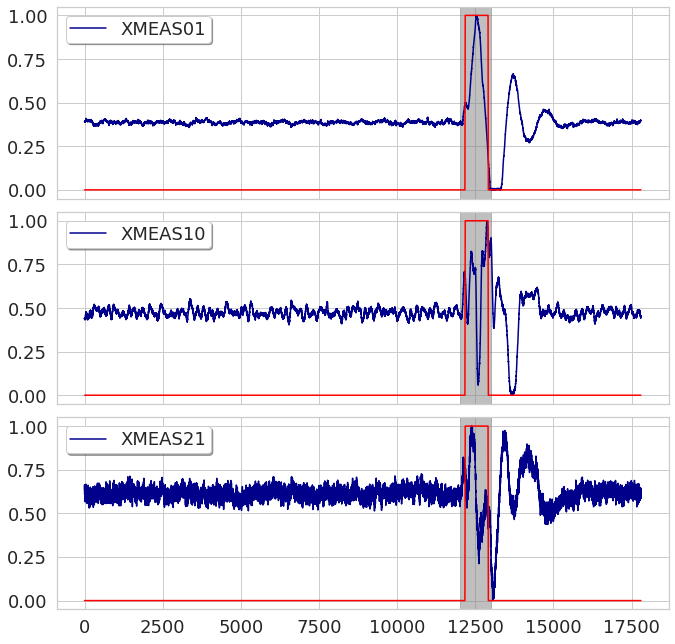

In [ ]:


def plot_predictions(dataset, modelo, target, falhas_localizacao_inicio, 
                     falhas_localizacao_fim, feature_names, title="",
                     figheight=3, figwidth=8, fontsize=16, xticks="TOUT"):
    y_test = modelo.predict(dataset)
    y_test =  1 * (y_test > 0.5)
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    num_plots = len(feature_names)
    colors = ["blue", "orange", "magenta", "pink"]
    fig, ax = plt.subplots(num_plots, 1, sharex=True, sharey=True)
    fig.subplots_adjust(top=0.98, bottom=0.05, left=0.10, right=0.95, hspace=0.07,
                        wspace=0.35)
    
    fig.set_figheight(figheight*num_plots)
    fig.set_figwidth(figwidth)
    fig.suptitle(title)
    window_len = modelo["sax"].window_size
    dataset_normalized = scaler.fit_transform(dataset[feature_names])
    # plt.xticks(fontsize=fontsize)
    # plt.yticks(fontsize=fontsize)
    
    for i in range(num_plots):
        ax[i].plot(dataset_normalized[:, i], label=feature_names[i], color="darkblue")
        ax[i].legend(loc="upper left", fancybox=True, 
                     shadow=True, borderpad=0.25,
                     fontsize=fontsize)
        ax[i].tick_params(axis="y", labelsize=fontsize)
        ax[i].tick_params(axis="x", labelsize=fontsize)
        ax[i].plot(np.arange(0, dataset_normalized.shape[0], window_len), y_test, color="red")
        for j in range(len(falhas_localizacao_inicio)):
            ax[i].axvspan(falhas_localizacao_inicio[j], falhas_localizacao_fim[j], color="grey", alpha=0.5)
    plt.show()

plot_predictions(falha8, modelo=detector, falhas_localizacao_inicio=[12000],
                 falhas_localizacao_fim=[13000], feature_names=feature_names,
                 title="", fontsize=18, figheight=3, figwidth=10, )

## Falha 1

In [ ]:
# Por recall
modelo_recall = training_neural_net(falha8, delays=2, alphabet_size=6,
                              window_size=10)

Memória ocupada antes da compressão (kB): 427.224
Memória ocupada após a compressão (kB): 42.744
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6137  0.4852
      2        0.2776  0.5161
      3        0.2975  0.4975
      4        0.2920  0.5018
      5        0.2881  0.4900
      6        0.2909  0.5055
      7        0.2915  0.5088
      8        0.2814  0.5013
      9        0.2806  0.4934
     10        0.2827  0.5054
     11        0.2858  0.4873
     12        0.2864  0.5065
     13        0.2741  0.4913
     14        0.5713  0.5346
     15        0.5947  0.4943
     16        0.2809  0.4949
     17        0.2815  0.4951
     18        0.2702  0.4942
     19        0.2659  0.5004
     20        0.2558  0.5060
     21        0.2437  0.5037
     22        0.2380  0.4914
     23        0.2354  0.4889
     24        0.2193  0.4982
     25        0.2122  0.4893
     26        0.2180  0.4929
     27        0.2136  0.4981
     28        0.2153  0.5023
   

Memória ocupada antes da compressão (kB): 379.224
Memória ocupada após a compressão (kB): 37.944


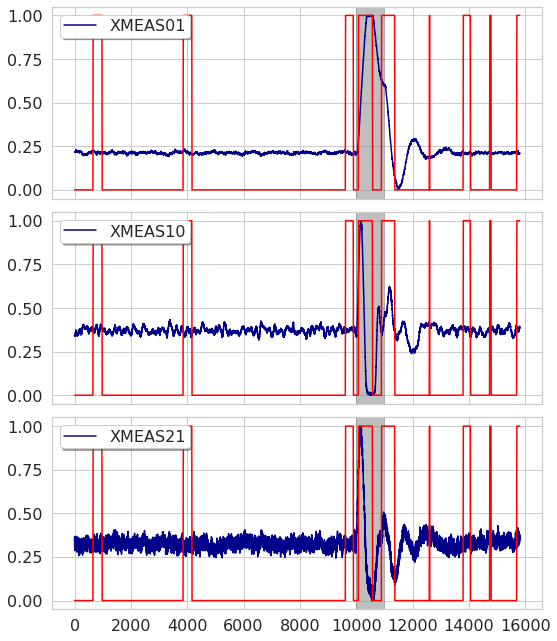

In [ ]:
plot_predictions(falha1, modelo=modelo_recall, falhas_localizacao_inicio=[10000],
                 falhas_localizacao_fim=[11000], feature_names=feature_names,
                 title="", fontsize=16, figheight=3, figwidth=8, )

In [ ]:
# Por f1
modelo_f1 = training_neural_net(falha8, delays=3, alphabet_size=5,
                              window_size=15)

Memória ocupada antes da compressão (kB): 427.224
Memória ocupada após a compressão (kB): 28.488
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5460  0.3435
      2        0.2507  0.3688
      3        0.2520  0.3705
      4        0.2559  0.3587
      5        0.2566  0.3510
      6        0.2547  0.3448
      7        0.2527  0.3659
      8        0.2467  0.3463
      9        0.2573  0.3420
     10        0.2509  0.3561
     11        0.2498  0.3419
     12        0.2430  0.3618
     13        0.2402  0.3518
     14        0.2451  0.3478
     15        0.2442  0.3437
     16        0.2379  0.3570
     17        0.2371  0.3382
     18        0.2341  0.3537
     19        0.2243  0.3556
     20        0.2180  0.3374
     21        0.2142  0.3417
     22        0.2086  0.3542
     23        0.2093  0.3381
     24        0.2034  0.3443
     25        0.2033  0.3508
     26        0.1938  0.3340
     27        0.1920  0.3449
     28        0.1818  0.3388
   

Memória ocupada antes da compressão (kB): 379.224
Memória ocupada após a compressão (kB): 25.296


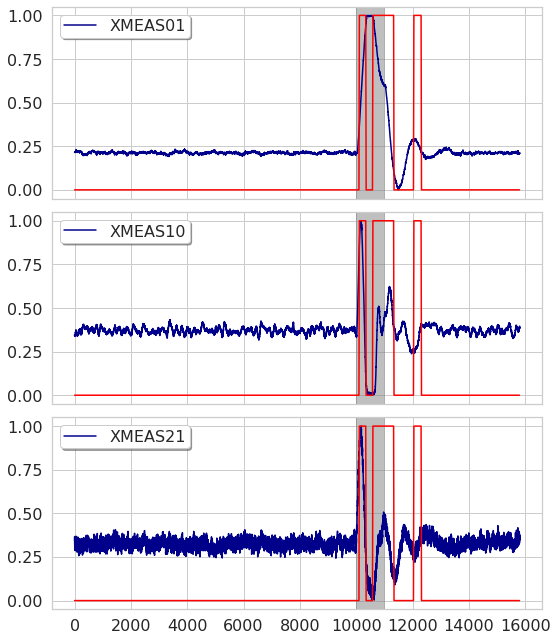

In [ ]:
plot_predictions(falha1, modelo=modelo_f1, falhas_localizacao_inicio=[10000],
                 falhas_localizacao_fim=[11000], feature_names=feature_names,
                 title="", fontsize=16, figheight=3, figwidth=8, )

In [ ]:
# Por precisão
modelo_precision = training_neural_net(falha8, delays=0, alphabet_size=3,
                              window_size=10)

Memória ocupada antes da compressão (kB): 427.224
Memória ocupada após a compressão (kB): 42.744
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5595  0.5003
      2        0.2807  0.5237
      3        0.2857  0.5046
      4        0.2804  0.5106
      5        0.2772  0.4956
      6        0.2733  0.5193
      7        0.2732  0.4960
      8        0.2774  0.5025
      9        0.2721  0.4972
     10        0.2740  0.5183
     11        0.2713  0.5185
     12        0.2666  0.4919
     13        0.2619  0.5105
     14        0.2661  0.5024
     15        0.2614  0.5195
     16        0.2613  0.5114
     17        0.2608  0.5145
     18        0.2623  0.4960
     19        0.2569  0.5101
     20        0.2571  0.4969
     21        0.2668  0.5121
     22        0.2560  0.4936
     23        0.2565  0.5052
     24        0.2528  0.4907
     25        0.2525  0.5122
     26        0.2521  0.5064
     27        0.2494  0.4945
     28        0.2505  0.4878
   

Memória ocupada antes da compressão (kB): 379.224
Memória ocupada após a compressão (kB): 37.944


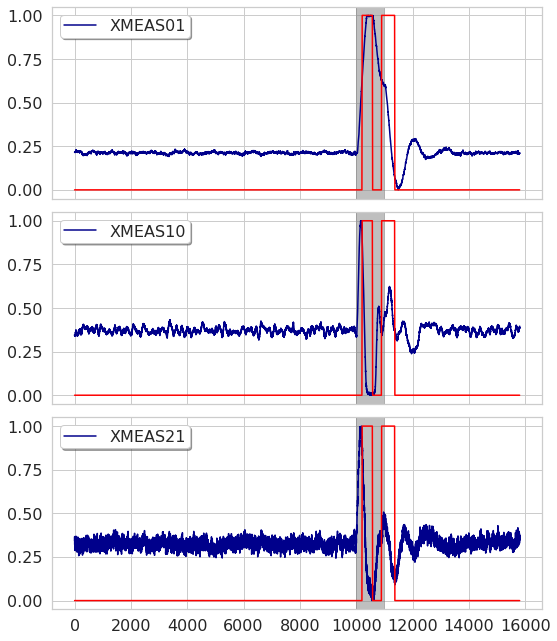

In [ ]:
plot_predictions(falha1, modelo=modelo_precision, falhas_localizacao_inicio=[10000],
                 falhas_localizacao_fim=[11000], feature_names=feature_names,
                 title="", fontsize=16, figheight=3, figwidth=8, )

In [ ]:
# Por precisão
modelo_artigo = training_neural_net(falha8, delays=3, alphabet_size=5,
                              window_size=15)

Memória ocupada antes da compressão (kB): 427.224
Memória ocupada após a compressão (kB): 28.488
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5460  0.3334
      2        0.2507  0.3525
      3        0.2520  0.3446
      4        0.2559  0.3417
      5        0.2566  0.3451
      6        0.2547  0.3377
      7        0.2527  0.3414
      8        0.2467  0.3518
      9        0.2573  0.3345
     10        0.2509  0.3295
     11        0.2498  0.3422
     12        0.2430  0.3337
     13        0.2402  0.3321
     14        0.2451  0.3421
     15        0.2442  0.3356
     16        0.2379  0.3284
     17        0.2371  0.3382
     18        0.2341  0.3294
     19        0.2243  0.3282
     20        0.2180  0.3465
     21        0.2142  0.3439
     22        0.2086  0.3383
     23        0.2093  0.3415
     24        0.2034  0.3291
     25        0.2033  0.3354
     26        0.1938  0.3544
     27        0.1920  0.3394
     28        0.1818  0.3374
   

Memória ocupada antes da compressão (kB): 379.224
Memória ocupada após a compressão (kB): 25.296


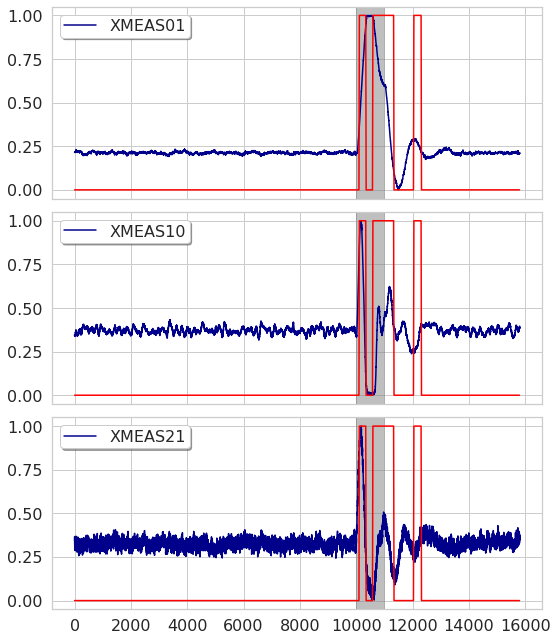

In [ ]:
plot_predictions(falha1, modelo=modelo_artigo, falhas_localizacao_inicio=[10000],
                 falhas_localizacao_fim=[11000], feature_names=feature_names,
                 title="", fontsize=16, figheight=3, figwidth=8, )